## 패키지

In [72]:
!pip install pymysql
!sudo apt-get install -y fonts-nanum # 나눔 폰트 설치 (설치 후 런타임 재시작하고 코드 실행)
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory

In [73]:
import numpy as np
import pandas as pd
import pymysql
from sqlalchemy import create_engine
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rc('font', family='NanumBarunGothic') # 한글 출력

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 로드

In [75]:
# DB 연결
endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema_name = 'dao'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema_name )
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

In [76]:
def sql_to_df(table_name):
    sql = "SELECT * FROM {}".format(table_name)
    df = pd.read_sql(sql, db_connection)
    return df

In [77]:
df_overpass = sql_to_df('MainData_overpass') # 육교형
df_tunnel = sql_to_df('MainData_tunnel') # 터널형

In [78]:
# 육교형 생태통로 MainData DF 정보
df_overpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                300 non-null    int64  
 1   위도                300 non-null    float64
 2   경도                300 non-null    float64
 3   생태통로_유형           300 non-null    int64  
 4   차선_수              300 non-null    int64  
 5   등산객_이용빈도          300 non-null    int64  
 6   생태통로_효율성          300 non-null    int64  
 7   이용확인종_수           300 non-null    int64  
 8   폭(m)              249 non-null    float64
 9   연장(m)             249 non-null    float64
 10  경사도               300 non-null    object 
 11  주변 로드킬 빈도         300 non-null    int64  
 12  산책로까지의 최단 거리(km)  300 non-null    float64
 13  농가까지의 거리(km)      300 non-null    float64
 14  도로 최고제한속도(km/h)   300 non-null    int64  
 15  주변 동물종 개수         300 non-null    int64  
 16  주변동물 출현빈도         300 non-null    int64  
 1

In [79]:
# 터널형 생태통로 MainData DF 정보
df_tunnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                197 non-null    int64  
 1   위도                197 non-null    float64
 2   경도                197 non-null    float64
 3   생태통로_유형           197 non-null    int64  
 4   차선_수              197 non-null    int64  
 5   등산객_이용빈도          197 non-null    int64  
 6   생태통로_효율성          197 non-null    int64  
 7   이용확인종_수           197 non-null    int64  
 8   폭(m)              21 non-null     float64
 9   연장(m)             22 non-null     float64
 10  높이(m)             21 non-null     float64
 11  개방도               22 non-null     float64
 12  경사도               197 non-null    object 
 13  주변 로드킬 빈도         197 non-null    int64  
 14  산책로까지의 최단 거리(km)  197 non-null    float64
 15  농가까지의 거리(km)      197 non-null    float64
 16  도로 최고제한속도(km/h)   197 non-null    int64  
 1

## 이상치 확인

In [80]:
# 이상치 처리해야 할 컬럼 목록
overpass_check = ['차선_수', '등산객_이용빈도', '이용확인종_수', '폭(m)', '연장(m)', '주변 로드킬 빈도', '산책로까지의 최단 거리(km)', 
                  '농가까지의 거리(km)', '도로 최고제한속도(km/h)', '주변 동물종 개수', '주변동물 출현빈도', '하천거리(km)', 
                  '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '환경영향평가점수', '건물까지거리(km)']

tunnel_check = ['차선_수', '등산객_이용빈도', '이용확인종_수', '폭(m)', '연장(m)', '높이(m)', '개방도', '주변 로드킬 빈도', 
                '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)', '주변 동물종 개수', '주변동물 출현빈도', 
                '하천거리(km)', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '환경영향평가점수', '건물까지거리(km)']

print(len(overpass_check))
print(len(tunnel_check))

18
20


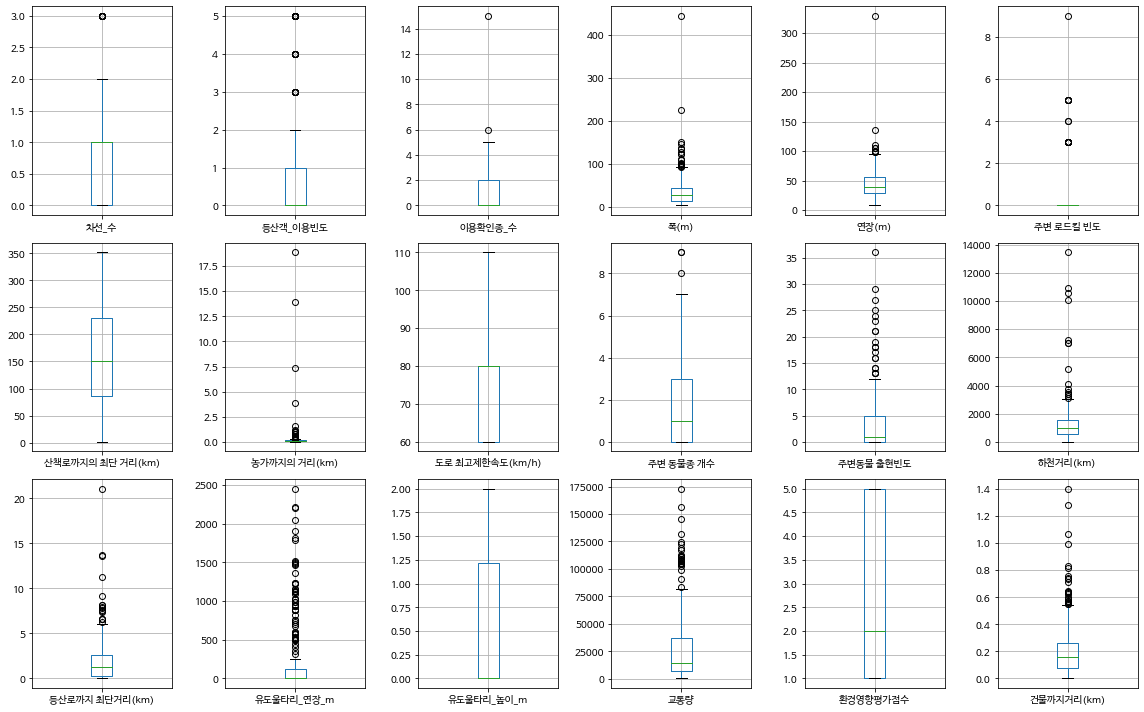

In [81]:
# 육교형 생태통로 Boxplot
plt.figure(figsize=(16, 10))

for i, col in enumerate(overpass_check):
  plt.subplot(3, 6, i+1)
  df_overpass.boxplot(col)

plt.tight_layout()
plt.show()

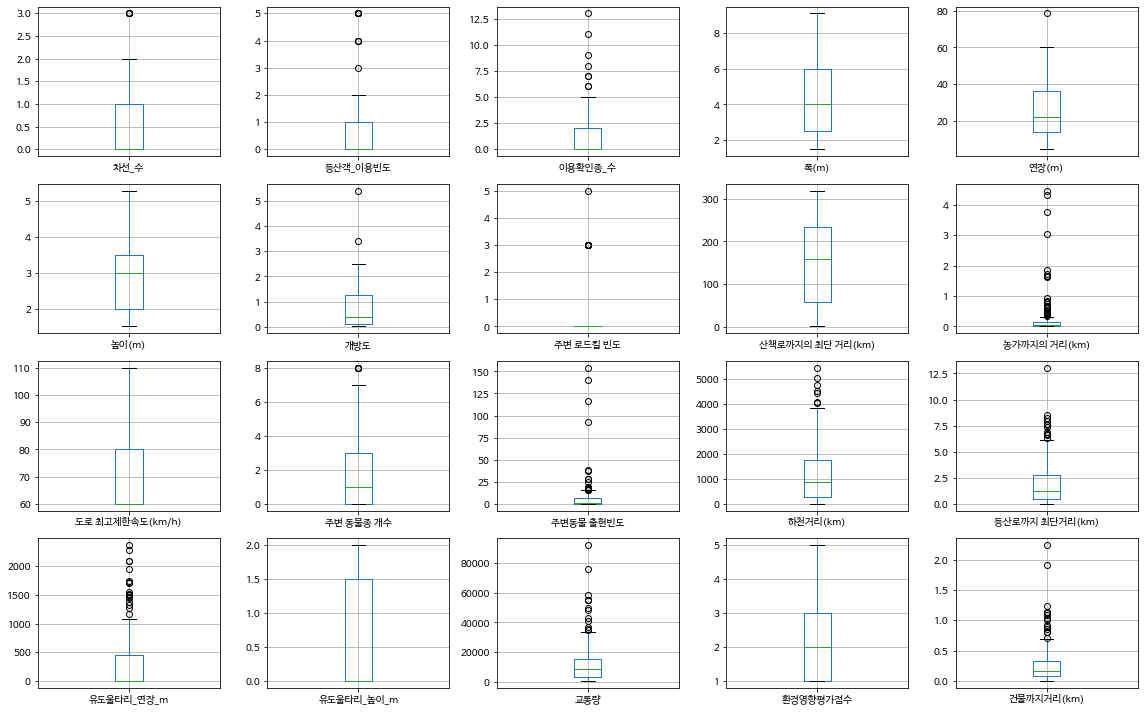

In [82]:
# 터널형 생태통로 Boxplot
plt.figure(figsize=(16, 10))

for i, col in enumerate(tunnel_check):
  plt.subplot(4, 5, i+1)
  df_tunnel.boxplot(col)

plt.tight_layout()
plt.show()

=> 육교형, 터널형 생태통로 데이터 모두 이상치가 모두 비이상적으로 큰 값들이므로, 모두 Boxplot의 **상한값**으로 대체

## 이상치 처리
Boxplot의 상한값으로 대체

In [83]:
# 높은 이상치는 Boxplot의 상한값으로, 낮은 이상치는 Boxplot의 하한값으로 대체하는 함수
def change_outlier(df, col_list):
  for col_name in col_list:
      Q1 = df[col_name].quantile(q=0.25)
      Q3 = df[col_name].quantile(q=0.75)
      IQR = Q3-Q1
      
      print('[' + col_name + ']', end=' ')
      high_idx = df[df[col_name] > (Q3+1.5*IQR)].index
      df.loc[high_idx, col_name] = round(Q3+1.5*IQR, 1)
      print(str(len(high_idx)) +'개가 상한값으로 변경됨', end=' / ')

      low_idx = df[df[col_name] < (Q1-1.5*IQR)].index
      df.loc[low_idx, col_name] = round(Q1-1.5*IQR, 1)
      print(str(len(low_idx)) +'개가 하한값으로 변경됨')

  return df

In [84]:
# 육교형 이상치 처리
df_overpass = change_outlier(df_overpass, overpass_check)

[차선_수] 9개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[등산객_이용빈도] 49개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[이용확인종_수] 2개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[폭(m)] 19개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[연장(m)] 9개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변 로드킬 빈도] 17개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[산책로까지의 최단 거리(km)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[농가까지의 거리(km)] 26개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[도로 최고제한속도(km/h)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변 동물종 개수] 3개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변동물 출현빈도] 19개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[하천거리(km)] 15개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[등산로까지 최단거리(km)] 16개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_연장_m] 59개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_높이_m] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[교통량] 28개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[환경영향평가점수] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[건물까지거리(km)] 23개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨


In [85]:
# 터널형 이상치 처리
df_tunnel = change_outlier(df_tunnel, tunnel_check) 

[차선_수] 5개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[등산객_이용빈도] 10개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[이용확인종_수] 8개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[폭(m)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[연장(m)] 1개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[높이(m)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[개방도] 2개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변 로드킬 빈도] 10개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[산책로까지의 최단 거리(km)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[농가까지의 거리(km)] 27개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[도로 최고제한속도(km/h)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변 동물종 개수] 5개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변동물 출현빈도] 16개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[하천거리(km)] 7개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[등산로까지 최단거리(km)] 12개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_연장_m] 18개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_높이_m] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[교통량] 13개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[환경영향평가점수] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[건물까지거리(km)] 14개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨


In [86]:
df_overpass.head(3)

,번호,위도,경도,생태통로_유형,차선_수,등산객_이용빈도,생태통로_효율성,이용확인종_수,폭(m),연장(m),...,식물군락명,등산로까지 최단거리(km),유도울타리_위도_2.3km,유도울타리_경도_2.3km,유도울타리_연장_m,유도울타리_높이_m,교통량,환경영향평가점수,건물까지거리(km),최우점식물군락
0,1495,35.36019,128.06375,0,1.0,1.0,3,0,NaN,NaN,...,소나무군락,3.157026,0.000000,0.000000,0.0,0.000000,7493.875,2,0.196597,소나무
1,1090,36.71051,127.42222,0,2.0,2.5,1,3,8.23,38.0,...,아까시나무-리기다소나무식재림,0.025083,36.708802,127.437539,298.8,1.571429,34542.400,5,0.172184,아까시나무
2,1023,37.41972,127.18750,0,0.0,1.0,2,4,25.10,13.0,...,신갈나무군락,0.003337,0.000000,0.000000,0.0,0.000000,53562.850,1,0.387330,신갈나무


In [87]:
df_tunnel.head(3)

,번호,위도,경도,생태통로_유형,차선_수,등산객_이용빈도,생태통로_효율성,이용확인종_수,폭(m),연장(m),...,식물군락명,등산로까지 최단거리(km),유도울타리_위도_2.3km,유도울타리_경도_2.3km,유도울타리_연장_m,유도울타리_높이_m,교통량,환경영향평가점수,건물까지거리(km),최우점식물군락
0,1277,37.03408,128.40661,1,0.0,0.0,3,0,NaN,NaN,...,소나무-신갈나무군락,1.087578,0.0,0.0,0,0.0,3573.857143,1,0.358139,소나무
1,1278,36.89832,128.30563,1,0.0,0.0,1,3,NaN,NaN,...,소나무군락,3.070682,0.0,0.0,0,0.0,3430.428571,2,0.139054,소나무
2,1279,36.89687,128.30581,1,0.0,0.0,1,3,NaN,NaN,...,소나무군락,2.921190,0.0,0.0,0,0.0,3430.428571,2,0.044559,소나무


In [88]:
# 이상치 처리된 MainData DF → DB로 업로드
# df_overpass.to_sql(name='MainData_outlier_overpass', con=db_connection, if_exists='replace', index=False)
# df_tunnel.to_sql(name='MainData_outlier_tunnel', con=db_connection, if_exists='replace', index=False)

## 결측치 처리
규격 데이터 (육교형 : 폭, 연장 / 터널형 : 폭, 연장, 높이, 개방도) 결측치 처리 필요 \
**!! 두 가지 방법(평균, KNN) 중 하나 선택 !!**

In [89]:
overpass_standard = ['폭(m)', '연장(m)'] # 육교형 규격 컬럼 리스트
tunnel_standard = ['폭(m)', '연장(m)', '높이(m)', '개방도'] # 터널형 규격 컬럼 리스트

### 1. 평균으로 대체

In [90]:
# 규격 데이터의 결측치를 평균으로 대치하는 함수(평균)
def MeanImputation(df, col_list):
  for col_name in col_list:
    df[col_name].fillna(np.round(df[col_name].mean(), 1), inplace=True)
  return df

### 2. KNN으로 대체

In [91]:
# KNN 알고리즘으로 결측값 대체 함수
def KNNImputation(df, col_list, n_neighbors):
  imputer = KNNImputer(n_neighbors=n_neighbors)
  filled = np.round(imputer.fit_transform(df[col_list]), 1)
  df[col_list] = pd.DataFrame(filled)
  return df

## 생태통로 효율성 데이터 처리
**!! 두 가지 방법(보통, 삭제) 중 하나 선택 !!**

### 1. '판단불가' 값을 '보통'으로 변경

In [92]:
# 생태통로 효율성 데이터의 '판단불가' 값을 중앙값('보통')으로 변경하는 함수
def change_median(df):
  df[df['생태통로_효율성'] == 3] = 1 # 1은 효율성 '보통'을 의미
  return df

### 2. '판단불가' 값을 삭제

In [93]:
# 생태통로 효율성 데이터가 '판단불가' 값이면 삭제하는 함수
def drop_value(df):
  df.drop(df[df['생태통로_효율성'] == 3].index, inplace=True)
  return df

## 데이터 전처리 수행
원하는 조합으로 함수 선택

In [94]:
# [Case 1] 결측치 : 평균 / 효율성 : 보통
df_overpass_tmp = MeanImputation(df_overpass, overpass_standard)
df_tunnel_tmp = MeanImputation(df_tunnel, tunnel_standard)

overpass_mean_median = change_median(df_overpass_tmp)
tunnel_mean_median = change_median(df_tunnel_tmp)


# [Case 2] 결측치 : 평균 / 효율성 : 삭제
df_overpass_tmp = MeanImputation(df_overpass, overpass_standard)
df_tunnel_tmp = MeanImputation(df_tunnel, tunnel_standard)

overpass_mean_drop = drop_value(df_overpass_tmp)
tunnel_mean_drop = drop_value(df_tunnel_tmp)


# [Case 3] 결측치 : KNN / 효율성 : 보통
for i in range(1, 6): # k 값을 1에서 5까지 모두 넣어보기
  df_overpass_tmp = KNNImputation(df_overpass, overpass_standard, i)
  df_tunnel_tmp = KNNImputation(df_tunnel, tunnel_standard, i)

  globals()['overpass_knn{}_mean'.format(i)] = change_median(df_overpass_tmp)
  globals()['tunnel_knn{}_mean'.format(i)] = change_median(df_tunnel_tmp)


# [Case 4] 결측치 : KNN / 효율성 : 삭제
for i in range(1, 6): # k 값을 1에서 5까지 모두 넣어보기
  df_overpass_tmp = KNNImputation(df_overpass, overpass_standard, i)
  df_tunnel_tmp = KNNImputation(df_tunnel, tunnel_standard, i)

  globals()['overpass_knn{}_drop'.format(i)] = drop_value(df_overpass_tmp)
  globals()['tunnel_knn{}_drop'.format(i)] = drop_value(df_tunnel_tmp)

## 최종 데이터

In [95]:
path = '/content/drive/MyDrive/2022 데이터 청년 캠퍼스/프로젝트/전처리/MainData 전처리 결과 데이터/'

In [96]:
overpass_mean_median.to_csv(path + 'overpass_mean_median.csv', index=False, encoding='cp949')
tunnel_mean_median.to_csv(path + 'tunnel_mean_median.csv', index=False, encoding='cp949')
overpass_mean_drop.to_csv(path + 'overpass_mean_drop.csv', index=False, encoding='cp949')
tunnel_mean_drop.to_csv(path + 'tunnel_mean_drop.csv', index=False, encoding='cp949')

for i in range(1, 6):
  globals()['overpass_knn{}_mean'.format(i)].to_csv(path + 'overpass_knn{}_mean.csv'.format(i), index=False, encoding='cp949')
  globals()['tunnel_knn{}_mean'.format(i)].to_csv(path + 'tunnel_knn{}_mean.csv'.format(i), index=False, encoding='cp949')
  globals()['overpass_knn{}_drop'.format(i)].to_csv(path + 'overpass_knn{}_drop.csv'.format(i), index=False, encoding='cp949')
  globals()['tunnel_knn{}_drop'.format(i)].to_csv(path + 'tunnel_knn{}_drop.csv'.format(i), index=False, encoding='cp949')